time series tutorial site: 

- 초보자를 위한 RNNs과 LSTM 가이드 https://deeplearning4j.org/kr/lstm
- TensorFlow Tutorial for Time Series Prediction https://github.com/tgjeon/TensorFlow-Tutorials-for-Time-Series
- TensorFlow-Time-Series-Examples https://github.com/hzy46/TensorFlow-Time-Series-Examples
- Predict Stock Prices Using RNN: Part 1 https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html
- Notes on LSTMs for Time Series Prediction in Finance http://bigtheta.io/2017/04/06/notes-on-lstms-in-finance.html
- Stock Market Predictions with LSTM in Python https://www.datacamp.com/community/tutorials/lstm-python-stock-market
- TIME SERIES DEEP LEARNING, PART 1: FORECASTING SUNSPOTS WITH KERAS STATEFUL LSTM IN R http://www.business-science.io/timeseries-analysis/2018/04/18/keras-lstm-sunspots-time-series-prediction.html
- RNN과 LSTM 을 이해해보자 https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/


 # Notes on LSTMs for Time Series Prediction in Finance
 
http://bigtheta.io/2017/04/06/notes-on-lstms-in-finance.html
 
 
 - problem 
 
 such as in the case of price data for equities, foreign exchange, futures markets in areas such as commodities, and the like. What makes forecasting TS for financial data so hard? Strong trends have high reversal rates, there exists large amounts of noisy movement, stochasticity, usually modeled with Brownian motion etc., and low seasonality or ability to make similar assumptions about movements.
 
 
 - statistic prediction
 
 The shortcomings of these approaches are obvious, relying only on data from the price series, and basic statistical tools, though reasonable results can be obtained for different types of TS data in academia, very little success is seen with respect to financial time series forecasting.
 
 
 - **LSTM**
 
 An LSTM is a variety of Recurrent Neural Network (RNN), which is itself a flavor of ANNs, the general class of artificial neural networks.
 
 
 - ANN 
 
 notable, there is no state dependency unless prior states (of a TS, for example) are fed in. This makes feedforward neural networks not particularly performant for TS prediction problems, especially in the case of chaotic price data.



- RNN  

 not only does the behavior of the network depend on the set of inputs, but also on all prior sets of inputs (to some reasonable limit, discussed later) which have given way to the current state of the network.
 
 
 - framwork 
 
 Keras, which is just a wrapper on top of both of the above frameworks, is the best choice in almost all cases. Fantastic documentation supplements an easy-to-use python API, which allows for the easy specification of models that can run on many backends and computing systems. Plays well with numpy and pandas, etc. Really, this is the best way to make your life easier.
 

# Stock Market Predictions with LSTM in Python
https://www.datacamp.com/community/tutorials/lstm-python-stock-market#average 

In [2]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

https://www.alphavantage.co/support/#api-key
    
Welcome to Alpha Vantage! Here is your API key: XFCQXP6HQNS1AJ6Z. 
Please record this API key for lifetime access to Alpha Vantage.

- Open: Opening stock price of the day
- Close: Closing stock price of the day
- High: Highest stock price of the data
- Low: Lowest stock price of the day

## Data Download

### Load Data 

In [3]:
df = pd.read_csv(os.path.join('stock-data/Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [4]:
# the order of the data is crucial in time series modelling.
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


### Data Visualization

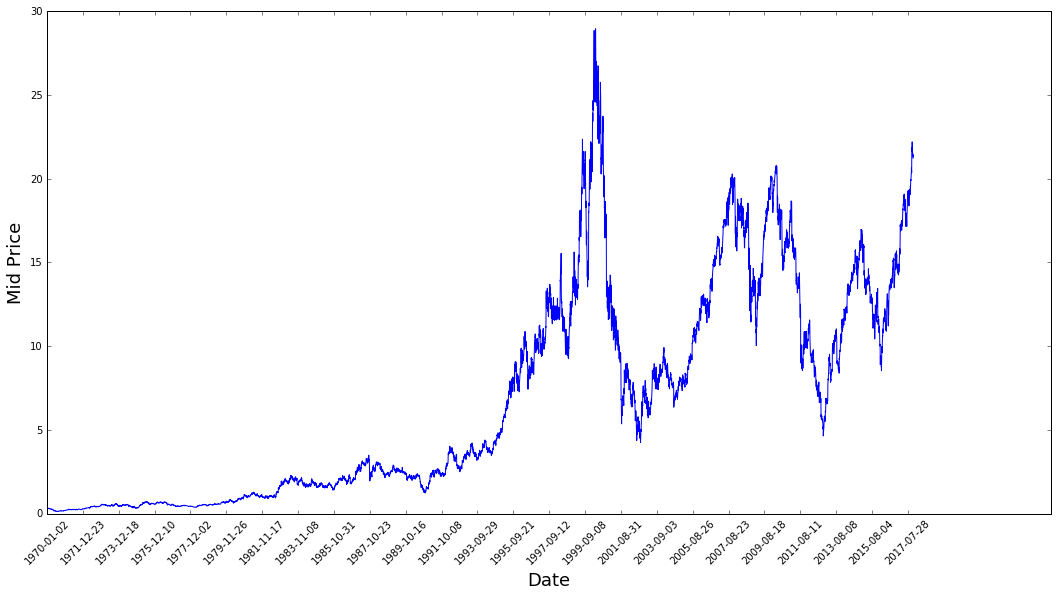

In [5]:
# various patterns occurring over time.
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), (df['Low']+df['High'])/2.0)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()

 The specific reason I picked this company over others is that this graph is bursting with different behaviors of stock prices over time. This will make the learning more robust as well as give you a change to test how good the predictions are for a variety of situations.

###  Splitting Data into a Training set and a Test set

In [6]:
high_prices = df.loc[:, 'High'].as_matrix()
low_prices = df.loc[:, 'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

In [7]:
mid_prices

array([  0.30627 ,   0.311975,   0.311905, ...,  21.355   ,  21.275   ,
        21.225   ])

In [8]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]
test_data

array([ 10.7975,  10.84  ,  10.789 , ...,  21.355 ,  21.275 ,  21.225 ])

## Normalizing the Data

window size : 시간간격 문제를 처리하기 위해 변종 데이터를 생성하는데 필요한 파라메터 

https://www.slideshare.net/hunkim/time-series-classification

이동 평균, 지수가중 이동평균 추가 설명 

http://statkclee.github.io/think-stat/html/thinkstats2013.html

In [9]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
test_data

array([[ 10.7975],
       [ 10.84  ],
       [ 10.789 ],
       ..., 
       [ 21.355 ],
       [ 21.275 ],
       [ 21.225 ]])

you normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. 

이전데이터의 영향도를 낮춤

Tip: when choosing the window size make sure it's not too small, because when you perform windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In [10]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0, 10000, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size, :])
    train_data[di:di+smoothing_window_size, :] = scaler.transform(train_data[di:di+smoothing_window_size, :])
    
# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:, :])
train_data[di+smoothing_window_size:, :] = scaler.transform(train_data[di+smoothing_window_size:, :])


In [11]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

train_data

array([ 0.31437908,  0.32384238,  0.32372627, ...,  0.38815567,
        0.38348085,  0.37614355])

You can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that you should only smooth training data.



In [12]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1 
for ti in range(11000):
    EMA = gamma*train_data[ti]+(1-gamma)*EMA
    train_data[ti] = EMA
    
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data, test_data], axis = 0)

## One-Step Ahead Prediction via Averaging

Averaging mechanisms allow you to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. 

미래의 주가를 이전에 관찰된 주가의 평균으로 나타냄

측정 : 
qualitatively (visual inspection) and quantitatively (Mean Squared Error)

### Standard Average

you will try to predict the future stock market prices (for example, xt+1) as an average of the previously observed stock market prices within a fixed size window (for example, xt-N, ..., xt) (say previous 100 days)

In [13]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size, N):
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx, 'Date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx - window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)
    
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


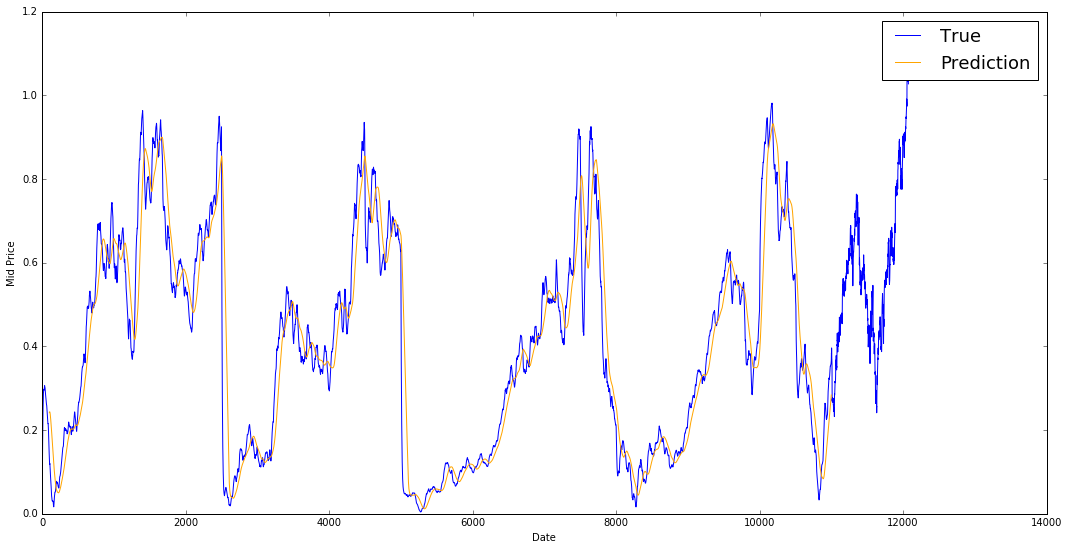

In [14]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

 a model for very short predictions (one day ahead).


### Exponential Moving Average

you will try a bit more fancier "exponential moving average" method and see how well that does. 

how you can replicate that behavior with a simple averaging method.

간단한 평균 수식으로 쉽게 복제 할수 있다. (optical illusions 시각적 환상에 속지마라) 

* xt+1 = EMAt = γ × EMAt-1 + (1-γ) xt where EMA0 = 0 and EMA is the exponential moving average value you maintain over time.

γ decides what the contribution of the most recent prediction is to the EMA. For example, a γ=0.1 gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average

γ 값은 최근의 예측이 EMA에 얼마나 기여하게 할지 결정한다. 평균에서 일찍본 오래된 값을 오래도록 유지 할 수 있다.

In [15]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0

run_avg_predictions.append(running_mean)

decay = 0.5 

for pred_idx in range(1,N):
    #γ × EMAt-1 + (1-γ) xt 
    running_mean = running_mean*decay + (1.0 - decay)* train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)
    
print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


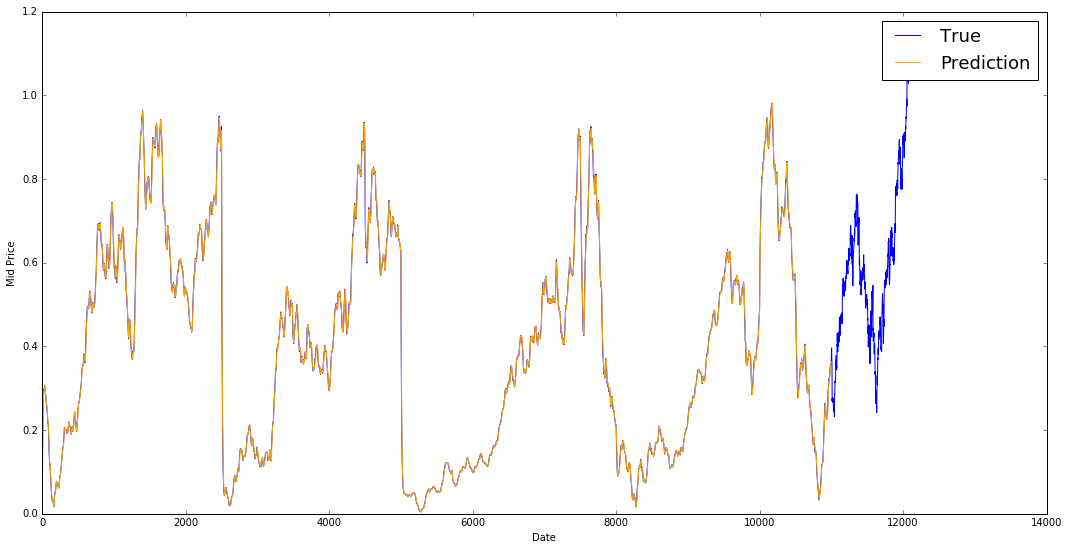

In [16]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

 you will expose the incapability of the EMA method.
 
 So no matter how many steps you predict in to the future, you'll keep getting the same answer for all the future prediction steps.
 
  1 탭 이상 예측하도록 수식을 바꾸면 그 수식은 동일한 예측만 하게 될 것이다. 

### Introduction to LSTMs: Making Stock Movement Predictions Far into the Future

* Cell state (ct) - This represents the internal memory of the cell which stores both short term memory and long-term memories
<br> 단기 메모리와 장기메모리 모두 저장 


* Hidden state (ht) - This is output state information calculated w.r.t. current input, previous hidden state and current cell input which you eventually use to predict the future stock market prices. Additionally, the hidden state can decide to only retrive the short or long-term or both types of memory stored in the cell state to make the next prediction.
<br> 현재 입력 정보를 current input, previous hidden state and current cell input 로 연산하여 나오는 아웃풋의 정보 


* Input gate (it) - Decides how much information from current input flows to the cell state
<br> 현제 인풋에서 얼마나 cell 정보에 보낼지 


* Forget gate (ft) - Decides how much information from the current input and the previous cell state flows into the current cell state
<br> 현재 인풋과 이전셀의 값을 current cell 에 얼마나 보낼지 


* Output gate (ot) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories
<br> 얼마나 많은 현재 셀을 히든 상태로 둘지 정한다. 장기기억 또는 장단기 기억 중에 선택 할떄 LSTM 을 쓸수 있따. 


### Data Generator





-------------------
강화학습 

다이나믹프로그래밍에서 발전 하나를 가면서 다 계산 

강화학습 몬테카를로 : 한번 다 돌고 죽거나 성공하면 값을 계산함

강화학습 살사 : 칸을 한번씩 갈때마다 계산 

강화학습 큐러닝 : 살사가 - 값이 있으면 움직이지 않으려 하는 단점이 있어서 이후 상태까지 고려해서 계산
